# Multivariate Analysis

In [2]:
from utils.feature_importance import feature_importance, metrics, summary_plot,multivariate_importance
from utils.plotting_functions import dual_heat_map
import joblib
from sklearn.pipeline import Pipeline
import optuna
from utils.Reg_Models import RegModels
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings # Ignore alert messages
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LassoLarsCV, LassoCV, Lasso

import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
df = pd.read_csv(r'C:\Users\DELL\Desktop\PG\nadal_fra6.csv',sep=';')

In [7]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=0,shuffle=False) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [8]:
X, y = df[['CC_FL','CC_BL','AT_Y','CC_BR','CC_FR',
'AU_395_L','AU_355_L','AT_X','AT_Z']], df[['L/V_FR']]
X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

## Distribuição dados Treino x Teste para essa distribuição

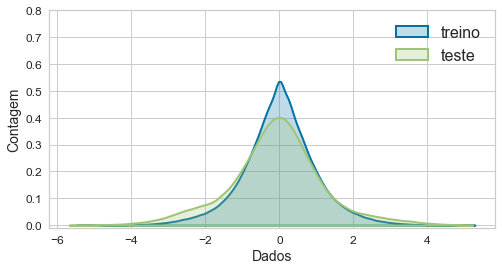

In [25]:
plt.figure(figsize=(8,4))
sns.distplot(X_train_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(X_test_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Dados", size=14)
plt.ylabel("Contagem", size=14)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
#plt.title("Dados treino x teste (X)")
plt.ylim([-0.01,0.8])

plt.legend(loc='upper right',fontsize=16)

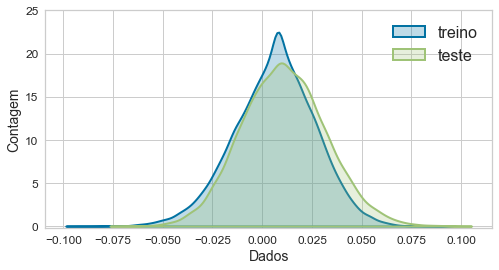

In [26]:
plt.figure(figsize=(8,4))
sns.distplot(y_train, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(y_test, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Dados", size=14)
plt.ylabel("Contagem", size=14)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.ylim([-0.2,25])
plt.legend(loc='upper right',fontsize=16)

A distribuição parece ser representativa, podemos seguir em frente

In [9]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import feature_importances
import xgboost as xgb
from sklearn.linear_model import ElasticNet
import eli5
from tqdm import tqdm
from eli5.sklearn import PermutationImportance



def summary_plot(model,X_train,y_train,X_test,y_test,cv,train_sizes=np.linspace(0.1,1.0,5),lc=False):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    plt.rc('legend',fontsize=12.5) 


    visualize_residuals = residuals_plot(model,X_train, y_train, X_test, y_test,show=False,ax=ax[0],title=' ');
    ax[0].tick_params(labelsize=13)
    ax[0].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[0].set_ylabel('Residuals (mm)',fontsize=16)

    visualizer = prediction_error(model, X_test, y_test, show=False, ax=ax[1], title=' ')
    ax[1].tick_params(labelsize=13)
    ax[1].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[1].set_ylabel('Real value (mm)',fontsize=16)

    if lc:
        print('Plotting learning curves')
        visual_LC = learning_curve(model, X_train, y_train,scoring='r2',cv=cv,ax=ax[2],title=' ',show=False,train_sizes=train_sizes,n_jobs=-1);
        ax[2].set_ylim([0.6, 1.05])
        ax[2].tick_params(labelsize=13)
        ax[2].set_xlabel('Number of training instances',fontsize=16)
        ax[2].set_ylabel(r'$R^2$' + ' metric',fontsize=16)
        
    plt.show()
    
    return


def metrics(y_test,predict):
    
    mse = mean_squared_error(y_test,predict)
    mae= mean_absolute_error(y_test,predict)
    r2= r2_score(y_test,predict)
    return print("MSE:{}".format(mse),"\nMAE:{}".format(mae),"\nR2:{}".format(r2))


def feature_importance(X_train,y_train,X_test,y_test,relative=True,topn=9):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10),sharex=True)
    plt.rc('legend',fontsize=12.5) 

    ################################################################
    # Lasso Regression
    ################################################################
    
    mod = Lasso(alpha=0.001)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    viz1 = FeatureImportances(Lasso(alpha=0.001),relative=relative,topn=topn, title =' ',ax=ax[0,0],absolute=True)
    viz1.fit(X_train,y_train)
    ax[0,0].tick_params(labelsize=13)
    ax[0,0].set_title('Lasso Regression - R^2 = {}'.format(r2),fontsize=20)

    ################################################################

    mod = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    rfr = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    viz2 = FeatureImportances(rfr,relative=relative, topn=topn, title =' ',ax=ax[0,1])
    viz2.fit(X_train,y_train)
    ax[0,1].tick_params(labelsize=13)
    ax[0,1].set_title('RandomForestRegressor - R^2 = {}'.format(r2),fontsize=20)
    
    ################################################################

    mod = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    abr = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    viz3 = FeatureImportances(abr,relative=relative, topn=topn, title =' ', ax=ax[1,0])
    viz3.fit(X_train,y_train)
    ax[1,0].tick_params(labelsize=13)
    ax[1,0].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,0].set_title('XGBoostRegressor - R^2 = {}'.format(r2),fontsize=20)
  
    ################################################################
    
    mod = ElasticNet(**study_en.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    gbr = ElasticNet(**study_en.best_params,random_state=2020)
    viz4 = FeatureImportances(gbr,relative=relative, topn=topn, title =' ',ax=ax[1,1])
    viz4.fit(X_train,y_train)
    ax[1,1].tick_params(labelsize=13)
    ax[1,1].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,1].set_title('ElasticNet - R^2 = {}'.format(r2),fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return


class multivariate_importance():
    def __init__(self, X_train, X_test, y_train, y_test, nmodels=6):

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.nmodels = nmodels

        mod1 = Lasso(alpha=0.001)
        mod2 = RandomForestRegressor(**study_rf.best_params,random_state=2020)
        mod3 = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
        mod4 = GradientBoostingRegressor(**study_rf.best_params,random_state=2020)
        mod5 = ExtraTreesRegressor(**study_et.best_params,random_state=2020, n_jobs=-1)
        mod6 = ElasticNet(**study_en.best_params,random_state=2020)

        self.mod_list = [mod1, mod2,
                         mod3, mod4,
                         mod5, mod6]

        self.mod_list = self.mod_list[0:self.nmodels]

        self.model_r2 = None

        print('All models for determining feature importance')
        print(self.mod_list)
        print('')

    def train_models(self):

        model_r2 = []
        for model in tqdm(self.mod_list):
            model.fit(self.X_train, self.y_train)
            model_r2.append(np.round(r2_score(self.y_test, model.predict(self.X_test)), 4))

        self.model_r2 = model_r2

        return model_r2

    def permutation_importance(self, model_index=1):

        self.mod_list[model_index].fit(self.X_train, self.y_train)
        perm = PermutationImportance(self.mod_list[model_index], random_state=1).fit(
            self.X_train, self.y_train)
        return eli5.show_weights(perm, feature_names=X_train.columns.tolist())

    def plot(self, relative=True, topn=9, absolute=True, plot_R2=True):

        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 18))

        if self.model_r2 == None:
            print('Obtaining R2 score for all 6 models')
            multivariate_importance.train_models(self)
            print('R2 score calculated')

        print('Obtaining feature importance - 0%')
        viz1 = FeatureImportances(self.mod_list[0], relative=relative, topn=topn, ax=ax[0, 0], absolute=absolute)
        viz1.fit(self.X_train, self.y_train)
        ax[0, 0].tick_params(labelsize=16)

        viz2 = FeatureImportances(self.mod_list[1], relative=relative, topn=topn, ax=ax[0, 1], absolute=absolute)
        viz2.fit(self.X_train, self.y_train)
        ax[0, 1].tick_params(labelsize=16)

        viz3 = FeatureImportances(self.mod_list[2], relative=relative, topn=topn, ax=ax[0, 2], absolute=absolute)
        viz3.fit(self.X_train, self.y_train)
        ax[0, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 50%')
        viz4 = FeatureImportances(self.mod_list[3], relative=relative, topn=topn, ax=ax[1, 0], absolute=absolute)
        viz4.fit(self.X_train, self.y_train)
        ax[1, 0].tick_params(labelsize=18)

        viz5 = FeatureImportances(self.mod_list[4], relative=relative, topn=topn, ax=ax[1, 1], absolute=absolute)
        viz5.fit(self.X_train, self.y_train)
        ax[1, 1].tick_params(labelsize=18)

        viz6 = FeatureImportances(self.mod_list[5], relative=relative, topn=topn, ax=ax[1, 2], absolute=absolute)
        viz6.fit(self.X_train, self.y_train)
        ax[1, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 100%')

        if plot_R2:

            ax[0, 0].set_title(
                'Lasso Regression - $R^2$ = {}'.format(self.model_r2[0]), fontsize=25)
            ax[0, 1].set_title(
                'RandomForestRegressor - $R^2$ = {}'.format(self.model_r2[1]), fontsize=25)
            ax[0, 2].set_title(
                'XGBoostRegressor - $R^2$ = {}'.format(self.model_r2[2]), fontsize=25)
            ax[1, 0].set_title(
                'GradientBoostingRegressor - $R^2$ = {}'.format(self.model_r2[3]), fontsize=25)
            ax[1, 1].set_title(
                'ExtraTreesRegressor - $R^2$ = {}'.format(self.model_r2[4]), fontsize=25)
            ax[1, 2].set_title(
                'ElasticNet - $R^2$ = {}'.format(self.model_r2[5]), fontsize=25)

            ax[0, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 0].set_xlim([0,0.1])
            #ax[0, 1].set_xlim([0,0.5])
            #ax[0, 2].set_xlim([0,0.5])
            #ax[1, 0].set_xlim([0,0.5])
            #ax[1, 1].set_xlim([0,0.5])
            ax[1, 2].set_xlim([0,0.1])

        plt.tight_layout()
        return


In [10]:
study_rf = joblib.load("study_RandomForest.pkl")
study_ab = joblib.load("study_AdaBost.pkl")
study_en = joblib.load("study_ElasticNet.pkl")
study_xgb = joblib.load("study_XGBoost.pkl")
study_et = joblib.load("study_Extratrees.pkl")


In [9]:
jalkkhkjhsfkhlajjç

NameError: name 'jalkkhkjhsfkhlajjç' is not defined

All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=32, max_features=6, min_samples_leaf=6,
                      min_samples_split=4, n_estimators=330, random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000001,
             tree_

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\1172260965.py:150: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(self.X_train, self.y_train)
 33%|███▎      | 2/6 [01:24<02:48, 42.23s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 50%|█████     | 3/6 [07:44<09:09, 183.16s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 67%|██████▋   | 4/6 [12:33<07:25, 2

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


Obtaining feature importance - 100%
CPU times: total: 26min 7s
Wall time: 12min 48s


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

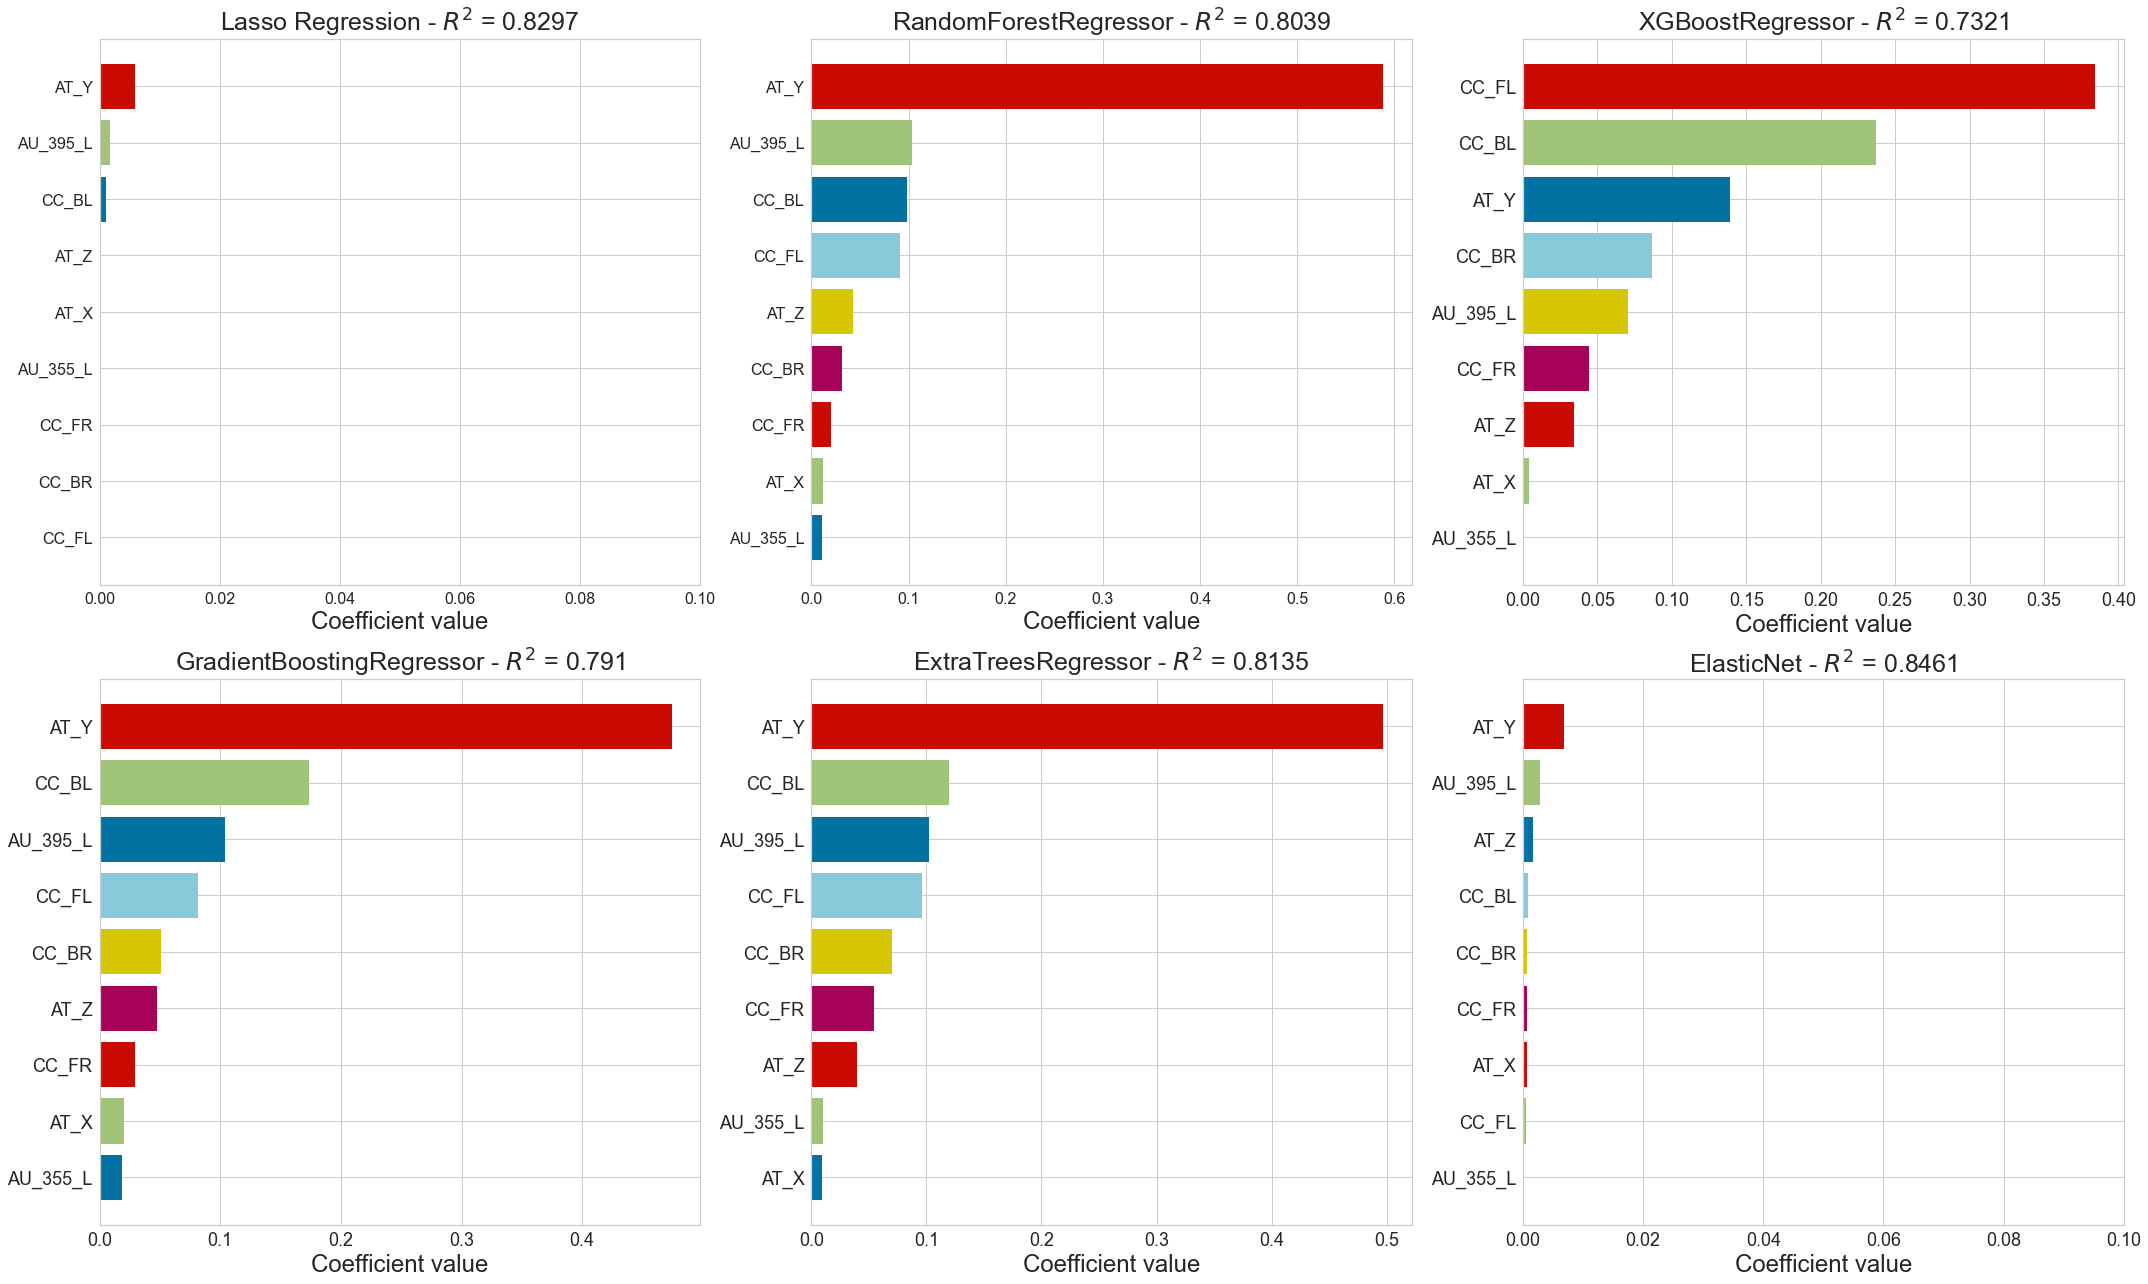

In [11]:
%%time
multi_select = multivariate_importance(X_train_scaled,X_test_scaled,y_train,y_test)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

# Optuna study

In [ ]:
#X, y = df_nadal[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
#'AU_395_FR','AU_395_FL','AU_275_FR','AU_275_FL']], df_nadal[['L/V_FR']]
#X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

### Random Forest - FR

In [12]:
import optuna

def objective(trial):
    
    joblib.dump(study, 'study.pkl')
    
    f_n_estimators = trial.suggest_int("n_estimators", low=200,high=1000,step=25)
    f_max_depth = trial.suggest_int("max_depth", low=2,high=50,step=2)
    f_min_samples_leaf = trial.suggest_int("min_samples_leaf", low=1, high=20, step=1)
    f_min_samples_split = trial.suggest_int("min_samples_split", low=2, high=20, step=1)
    int_max_features = np.arange(2,len(X_train_scaled.columns),1,dtype=int) 
    max_features_list = []
    for e in int_max_features: 
       max_features_list.append(int(e))
    f_max_features = trial.suggest_categorical("max_features",max_features_list) 
     
    model = RandomForestRegressor(max_depth=f_max_depth,
                                           n_estimators = f_n_estimators,
                                           min_samples_split = f_min_samples_split,
                                           min_samples_leaf = f_min_samples_leaf,
                                           max_features = f_max_features,
                                           random_state=0, 
                                           n_jobs = -1)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study = optuna.create_study(direction='maximize')

[I 2022-12-09 12:17:54,919] A new study created in memory with name: no-name-8727386c-7a28-402d-9b9a-30ba829a64f3


In [13]:
study.optimize(objective, n_trials=50,show_progress_bar=True)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:18:35,744] Trial 0 finished with value: 0.8019374821142056 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 8, 'max_features': 5}. Best is trial 0 with value: 0.8019374821142056.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:19:28,666] Trial 1 finished with value: 0.8021745215316305 and parameters: {'n_estimators': 675, 'max_depth': 34, 'min_samples_leaf': 9, 'min_samples_split': 18, 'max_features': 5}. Best is trial 1 with value: 0.8021745215316305.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:19:57,455] Trial 2 finished with value: 0.8058649651262927 and parameters: {'n_estimators': 250, 'max_depth': 16, 'min_samples_leaf': 14, 'min_samples_split': 7, 'max_features': 8}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:20:35,534] Trial 3 finished with value: 0.8037900465116409 and parameters: {'n_estimators': 375, 'max_depth': 28, 'min_samples_leaf': 5, 'min_samples_split': 15, 'max_features': 6}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:21:38,325] Trial 4 finished with value: 0.8012369179861379 and parameters: {'n_estimators': 800, 'max_depth': 8, 'min_samples_leaf': 19, 'min_samples_split': 16, 'max_features': 8}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:22:22,744] Trial 5 finished with value: 0.7773689507233282 and parameters: {'n_estimators': 950, 'max_depth': 20, 'min_samples_leaf': 19, 'min_samples_split': 11, 'max_features': 3}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:23:51,520] Trial 6 finished with value: 0.8025973268491088 and parameters: {'n_estimators': 975, 'max_depth': 20, 'min_samples_leaf': 12, 'min_samples_split': 10, 'max_features': 6}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:24:24,270] Trial 7 finished with value: 0.8074776603090736 and parameters: {'n_estimators': 250, 'max_depth': 24, 'min_samples_leaf': 2, 'min_samples_split': 3, 'max_features': 7}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:24:57,561] Trial 8 finished with value: 0.8057202151285705 and parameters: {'n_estimators': 300, 'max_depth': 14, 'min_samples_leaf': 12, 'min_samples_split': 15, 'max_features': 8}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:25:45,477] Trial 9 finished with value: 0.8002290007036692 and parameters: {'n_estimators': 625, 'max_depth': 28, 'min_samples_leaf': 13, 'min_samples_split': 17, 'max_features': 5}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:27:00,521] Trial 10 finished with value: 0.8052740549527139 and parameters: {'n_estimators': 475, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 3, 'max_features': 7}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:27:09,768] Trial 11 finished with value: 0.6227449122057206 and parameters: {'n_estimators': 225, 'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 3, 'max_features': 7}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:27:28,140] Trial 12 finished with value: 0.7620327520848026 and parameters: {'n_estimators': 450, 'max_depth': 38, 'min_samples_leaf': 8, 'min_samples_split': 6, 'max_features': 2}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:27:39,917] Trial 13 finished with value: 0.7892115583397517 and parameters: {'n_estimators': 200, 'max_depth': 12, 'min_samples_leaf': 16, 'min_samples_split': 6, 'max_features': 4}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:29:07,786] Trial 14 finished with value: 0.8075331691248306 and parameters: {'n_estimators': 500, 'max_depth': 42, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_features': 8}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:30:27,448] Trial 15 finished with value: 0.8056878725532631 and parameters: {'n_estimators': 500, 'max_depth': 48, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:31:13,940] Trial 16 finished with value: 0.7913350436171012 and parameters: {'n_estimators': 750, 'max_depth': 40, 'min_samples_leaf': 5, 'min_samples_split': 4, 'max_features': 3}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:31:37,139] Trial 17 finished with value: 0.768486622774591 and parameters: {'n_estimators': 550, 'max_depth': 34, 'min_samples_leaf': 3, 'min_samples_split': 20, 'max_features': 2}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:32:05,160] Trial 18 finished with value: 0.7977848589590035 and parameters: {'n_estimators': 400, 'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 12, 'max_features': 4}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:33:01,077] Trial 19 finished with value: 0.8060697068512659 and parameters: {'n_estimators': 325, 'max_depth': 32, 'min_samples_leaf': 3, 'min_samples_split': 5, 'max_features': 8}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:34:59,593] Trial 20 finished with value: 0.8067453985807459 and parameters: {'n_estimators': 850, 'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 9, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:37:05,867] Trial 21 finished with value: 0.8066381893717501 and parameters: {'n_estimators': 850, 'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 2, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:38:47,865] Trial 22 finished with value: 0.8061888136876254 and parameters: {'n_estimators': 700, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 8, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:40:02,964] Trial 23 finished with value: 0.8065283598204309 and parameters: {'n_estimators': 600, 'max_depth': 22, 'min_samples_leaf': 3, 'min_samples_split': 4, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:41:48,739] Trial 24 finished with value: 0.8060744912052696 and parameters: {'n_estimators': 875, 'max_depth': 38, 'min_samples_leaf': 6, 'min_samples_split': 13, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:42:58,225] Trial 25 finished with value: 0.8063224078800748 and parameters: {'n_estimators': 550, 'max_depth': 26, 'min_samples_leaf': 10, 'min_samples_split': 9, 'max_features': 8}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:43:54,319] Trial 26 finished with value: 0.8050568530550313 and parameters: {'n_estimators': 425, 'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:44:59,315] Trial 27 finished with value: 0.7992879388839863 and parameters: {'n_estimators': 900, 'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_features': 4}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:45:32,187] Trial 28 finished with value: 0.7613160137695267 and parameters: {'n_estimators': 750, 'max_depth': 24, 'min_samples_leaf': 6, 'min_samples_split': 7, 'max_features': 2}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:45:58,373] Trial 29 finished with value: 0.7935568077611715 and parameters: {'n_estimators': 350, 'max_depth': 34, 'min_samples_leaf': 4, 'min_samples_split': 8, 'max_features': 3}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:46:36,296] Trial 30 finished with value: 0.8036644593424266 and parameters: {'n_estimators': 275, 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 6}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:48:50,054] Trial 31 finished with value: 0.8067932809927512 and parameters: {'n_estimators': 875, 'max_depth': 24, 'min_samples_leaf': 2, 'min_samples_split': 2, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:50:48,703] Trial 32 finished with value: 0.8060701175554359 and parameters: {'n_estimators': 800, 'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 3, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:52:26,747] Trial 33 finished with value: 0.8019310498810466 and parameters: {'n_estimators': 1000, 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_features': 5}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:53:35,571] Trial 34 finished with value: 0.8088443068300946 and parameters: {'n_estimators': 675, 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 7}. Best is trial 34 with value: 0.8088443068300946.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:54:23,118] Trial 35 finished with value: 0.7761585919803281 and parameters: {'n_estimators': 675, 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 5, 'max_features': 8}. Best is trial 34 with value: 0.8088443068300946.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:55:22,819] Trial 36 finished with value: 0.8099171028675878 and parameters: {'n_estimators': 525, 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 7}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:56:22,452] Trial 37 finished with value: 0.807720623398656 and parameters: {'n_estimators': 575, 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 6, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:57:15,643] Trial 38 finished with value: 0.8045149378416766 and parameters: {'n_estimators': 550, 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 6, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:57:33,734] Trial 39 finished with value: 0.43491515096113353 and parameters: {'n_estimators': 625, 'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 7, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:58:30,399] Trial 40 finished with value: 0.8059090311304014 and parameters: {'n_estimators': 500, 'max_depth': 12, 'min_samples_leaf': 17, 'min_samples_split': 4, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:59:17,438] Trial 41 finished with value: 0.80390471125803 and parameters: {'n_estimators': 600, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 3, 'max_features': 6}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:00:22,608] Trial 42 finished with value: 0.8036795327183375 and parameters: {'n_estimators': 650, 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 5}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:01:23,475] Trial 43 finished with value: 0.8066804849229772 and parameters: {'n_estimators': 725, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:02:15,575] Trial 44 finished with value: 0.8074987020525253 and parameters: {'n_estimators': 525, 'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 6, 'max_features': 7}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:03:19,154] Trial 45 finished with value: 0.8080657003556342 and parameters: {'n_estimators': 525, 'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 7, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:04:17,534] Trial 46 finished with value: 0.8055836725632473 and parameters: {'n_estimators': 450, 'max_depth': 18, 'min_samples_leaf': 12, 'min_samples_split': 8, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:05:30,365] Trial 47 finished with value: 0.8074135848107116 and parameters: {'n_estimators': 575, 'max_depth': 14, 'min_samples_leaf': 7, 'min_samples_split': 7, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:06:02,667] Trial 48 finished with value: 0.7752492891169203 and parameters: {'n_estimators': 475, 'max_depth': 6, 'min_samples_leaf': 11, 'min_samples_split': 11, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:06:10,861] Trial 49 finished with value: 0.2354682880688329 and parameters: {'n_estimators': 650, 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 4, 'max_features': 3}. Best is trial 36 with value: 0.8099171028675878.
Accuracy: 0.8099171028675878
Best hyperparameters: {'n_estimators': 525, 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 7}


In [14]:
joblib.dump(study, "study_RandomForest_FR_FRA6.pkl")

['study_RandomForest_FR_FRA6.pkl']

In [15]:
study.best_trial

FrozenTrial(number=36, values=[0.8099171028675878], datetime_start=datetime.datetime(2022, 12, 9, 12, 54, 23, 127016), datetime_complete=datetime.datetime(2022, 12, 9, 12, 55, 22, 819444), params={'n_estimators': 525, 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 7}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=200, step=25), 'max_depth': IntDistribution(high=50, log=False, low=2, step=2), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'max_features': CategoricalDistribution(choices=(2, 3, 4, 5, 6, 7, 8))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=36, state=TrialState.COMPLETE, value=None)

In [16]:
optuna.visualization.plot_optimization_history(study)

In [17]:
optuna.visualization.plot_slice(study)

### Extra-Trees Regressor

In [18]:
from sklearn.ensemble import ExtraTreesRegressor

def objective(trial):
    
        
    param = {
        'n_estimators': trial.suggest_int('n_estimators',200,800,25),
        'max_depth': trial.suggest_int('max_depth',2,20,2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,10,1),
        'random_state': 2020,
        #'max_leaf_nodes': trial.suggest_int('max_leaf_nodes',1,1000,25),
       
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf',0.0,0.2,step=0.01),
    
    }
    
    model = ExtraTreesRegressor(**param)    
  
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_ext = optuna.create_study(direction='maximize')

[I 2022-12-09 13:10:20,659] A new study created in memory with name: no-name-f2fea36f-3ed4-4d42-a7f6-5b187bed0983


In [19]:
study_ext.optimize(objective, n_trials=100,show_progress_bar=True)

trial_ext = study_ext.best_trial

print('Accuracy: {}'.format(trial_ext.value))
print("Best hyperparameters: {}".format(trial_ext.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-09 13:10:33,199] Trial 0 finished with value: 0.399219684623596 and parameters: {'n_estimators': 800, 'max_depth': 4, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.04}. Best is trial 0 with value: 0.399219684623596.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-09 13:10:36,923] Trial 1 finished with value: 0.19446238131446758 and parameters: {'n_estimators': 525, 'max_depth': 4, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.12}. Best is trial 0 with value: 0.399219684623596.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-09 13:10:40,180] Trial 2 finished with value: 0.2108751867458778 and parameters: {'n_estimators': 525, 'max_depth': 2, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.11}. Best is trial 0 with value: 0.399219684623596.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-09 13:10:42,841] Trial 3 finished with value: 0.21505165187199526 and parameters: {'n_estimators': 425, 'max_depth': 6, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.11}. Best is trial 0 with value: 0.399219684623596.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[W 2022-12-09 13:10:45,084] Trial 4 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py", line 19, in objective
    model.fit(X_train_scaled,y_train)
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch

KeyboardInterrupt: 

In [ ]:
joblib.dump(study_ext, "study_ExtraTrees.pkl")

['study_ExtraTrees.pkl']

In [ ]:
optuna.visualization.plot_optimization_history(study_ext)

In [ ]:
optuna.visualization.plot_slice(study_ext)

### ElasticNet

In [47]:
from sklearn.linear_model import ElasticNet

def objective(trial):
    
        
    h_alpha = trial.suggest_float("alpha", low=0.0001, high=1, step=0.0001)
    h_l1_ratio= trial.suggest_float("l1_ratio", low=0.0, high=0.5,step=0.01)
    
    h_selection = trial.suggest_categorical("selection", ['cyclic','random'])
    
    model = ElasticNet(alpha=h_alpha,l1_ratio=h_l1_ratio,
                                       
                                       selection=h_selection,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_en = optuna.create_study(direction='maximize')

[I 2022-12-09 13:19:09,267] A new study created in memory with name: no-name-17aa540e-9d37-487a-9009-596640f08d51


In [48]:
study_en.optimize(objective, n_trials=500,show_progress_bar=True)

trial_en = study_en.best_trial

print('Accuracy: {}'.format(trial_en.value))
print("Best hyperparameters: {}".format(trial_en.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-12-09 13:19:13,191] Trial 0 finished with value: 0.2166703806138658 and parameters: {'alpha': 0.2863, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 0 with value: 0.2166703806138658.
[I 2022-12-09 13:19:13,220] Trial 1 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.2719, 'l1_ratio': 0.5, 'selection': 'cyclic'}. Best is trial 0 with value: 0.2166703806138658.
[I 2022-12-09 13:19:13,258] Trial 2 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.49410000000000004, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 0 with value: 0.2166703806138658.
[I 2022-12-09 13:19:13,282] Trial 3 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.8439, 'l1_ratio': 0.16, 'selection': 'random'}. Best is trial 0 with value: 0.2166703806138658.
[I 2022-12-09 13:19:13,304] Trial 4 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.3831, 'l1_ratio': 0.23, 'selection': 'random'}. Best is trial 0 with value: 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.378e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:19:14,177] Trial 12 finished with value: 0.8399724553615713 and parameters: {'alpha': 0.1704, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 12 with value: 0.8399724553615713.
[I 2022-12-09 13:19:14,211] Trial 13 finished with value: 0.7021158046036484 and parameters: {'alpha': 0.2141, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 12 with value: 0.8399724553615713.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.445e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:19:15,065] Trial 14 finished with value: 0.8394699418190866 and parameters: {'alpha': 0.1783, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 12 with value: 0.8399724553615713.
[I 2022-12-09 13:19:15,109] Trial 15 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.13319999999999999, 'l1_ratio': 0.09, 'selection': 'cyclic'}. Best is trial 12 with value: 0.8399724553615713.
[I 2022-12-09 13:19:15,149] Trial 16 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.6022000000000001, 'l1_ratio': 0.18, 'selection': 'cyclic'}. Best is trial 12 with value: 0.8399724553615713.
[I 2022-12-09 13:19:15,231] Trial 17 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.1796, 'l1_ratio': 0.35000000000000003, 'selection': 'cyclic'}. Best is trial 12 with value: 0.8399724553615713.
[I 2022-12-09 13:19:15,283] Trial 18 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.9668, 'l1_ratio': 0.06, 'selection': 'ra

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.809e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:19:16,112] Trial 21 finished with value: 0.8364298644289527 and parameters: {'alpha': 0.224, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 12 with value: 0.8399724553615713.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.759e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:19:16,875] Trial 22 finished with value: 0.8261316462788175 and parameters: {'alpha': 0.3647, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 12 with value: 0.8399724553615713.
[I 2022-12-09 13:19:16,925] Trial 23 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.2352, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 12 with value: 0.8399724553615713.
[I 2022-12-09 13:19:16,961] Trial 24 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.12210000000000001, 'l1_ratio': 0.2, 'selection': 'cyclic'}. Best is trial 12 with value: 0.8399724553615713.
[I 2022-12-09 13:19:17,006] Trial 25 finished with value: 0.8506217473189062 and parameters: {'alpha': 0.004200000000000001, 'l1_ratio': 0.09, 'selection': 'cyclic'}. Best is trial 25 with value: 0.8506217473189062.
[I 2022-12-09 13:19:17,051] Trial 26 finished with value: 0.3583854780230601 and parameters: {'alpha': 0.0732, 'l1_ratio': 0.07, 'selection': 'random'}. Best is tr

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.749e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:19:20,019] Trial 64 finished with value: 0.8112824605105472 and parameters: {'alpha': 0.5503, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 39 with value: 0.8515983899180322.
[I 2022-12-09 13:19:20,063] Trial 65 finished with value: 0.7099147359651317 and parameters: {'alpha': 0.113, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 39 with value: 0.8515983899180322.
[I 2022-12-09 13:19:20,106] Trial 66 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.8268, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 39 with value: 0.8515983899180322.
[I 2022-12-09 13:19:20,144] Trial 67 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.1522, 'l1_ratio': 0.42, 'selection': 'cyclic'}. Best is trial 39 with value: 0.8515983899180322.
[I 2022-12-09 13:19:20,192] Trial 68 finished with value: 0.8397438676388893 and parameters: {'alpha': 0.0627, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 39 with value: 0.851598

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.603e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:19:21,311] Trial 79 finished with value: 0.8382116984528049 and parameters: {'alpha': 0.1976, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 39 with value: 0.8515983899180322.
[I 2022-12-09 13:19:21,345] Trial 80 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.052500000000000005, 'l1_ratio': 0.18, 'selection': 'cyclic'}. Best is trial 39 with value: 0.8515983899180322.
[I 2022-12-09 13:19:21,383] Trial 81 finished with value: 0.8516376813315946 and parameters: {'alpha': 0.004300000000000001, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:21,425] Trial 82 finished with value: 0.7491981415581632 and parameters: {'alpha': 0.025500000000000002, 'l1_ratio': 0.08, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:21,461] Trial 83 finished with value: 0.765378952758654 and parameters: {'alpha': 0.08750000000000001, 'l1_ratio': 0.02, 'selecti

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.629e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:19:23,162] Trial 111 finished with value: 0.8463257598262401 and parameters: {'alpha': 0.005600000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:23,204] Trial 112 finished with value: 0.8499695745548881 and parameters: {'alpha': 0.0178, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:23,238] Trial 113 finished with value: 0.7727433365418639 and parameters: {'alpha': 0.03540000000000001, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:23,276] Trial 114 finished with value: 0.7747363305099549 and parameters: {'alpha': 0.0568, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:23,308] Trial 115 finished with value: 0.8489849763516691 and parameters: {'alpha': 0.0204, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.198e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:19:24,130] Trial 122 finished with value: 0.8460117637044755 and parameters: {'alpha': 0.051000000000000004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:24,174] Trial 123 finished with value: 0.8350688891864813 and parameters: {'alpha': 0.0211, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:24,212] Trial 124 finished with value: 0.8255383317197277 and parameters: {'alpha': 0.0333, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:24,242] Trial 125 finished with value: 0.40407118198348857 and parameters: {'alpha': 0.06870000000000001, 'l1_ratio': 0.07, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:24,276] Trial 126 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.517, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best i

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.604e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:19:25,062] Trial 131 finished with value: 0.8462557197284255 and parameters: {'alpha': 0.0038, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:25,144] Trial 132 finished with value: 0.8470236822405164 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:25,175] Trial 133 finished with value: 0.7731276978914168 and parameters: {'alpha': 0.05740000000000001, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:25,211] Trial 134 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.08760000000000001, 'l1_ratio': 0.2, 'selection': 'cyclic'}. Best is trial 81 with value: 0.8516376813315946.
[I 2022-12-09 13:19:25,242] Trial 135 finished with value: 0.7395948447687459 and parameters: {'alpha': 0.035300000000000005, 'l1_ratio': 0.06, 'selection': 'cycl

In [22]:
joblib.dump(study_en, "study_ElasticNet_FR_FRA6.pkl")

['study_ElasticNet_FR_FRA6.pkl']

In [23]:
study_en.best_trial

FrozenTrial(number=287, values=[0.8518370627367615], datetime_start=datetime.datetime(2022, 12, 9, 13, 11, 31, 134794), datetime_complete=datetime.datetime(2022, 12, 9, 13, 11, 31, 190644), params={'alpha': 0.0009000000000000001, 'l1_ratio': 0.27, 'selection': 'random'}, distributions={'alpha': FloatDistribution(high=1.0, log=False, low=0.0001, step=0.0001), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=0.01), 'selection': CategoricalDistribution(choices=('cyclic', 'random'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=287, state=TrialState.COMPLETE, value=None)

In [24]:
optuna.visualization.plot_optimization_history(study_en)

In [25]:
optuna.visualization.plot_slice(study_en)

In [51]:
mdl = ElasticNet(**study_en.best_params,random_state=2020)
mdl.fit(X_train_scaled,y_train)
p=mdl.predict(X_test_scaled)
score= mean_squared_error(y_test,p)
score_r2 = r2_score(y_test,p)
print("RMSE: ", score)
print("R2: ", score_r2)
predito = np.array(p,dtype=float)
real= np.array(y_test,dtype=float)

RMSE:  2.8604004225153365e-05
R2:  0.8518350424239297


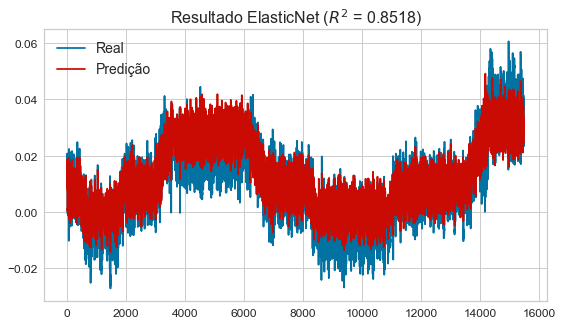

In [52]:
plt.figure(figsize=(9,5))
plt.plot(real,'b',label='Real')
plt.plot(predito,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2$ = 0.8518)',size=16)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(fontsize=14)

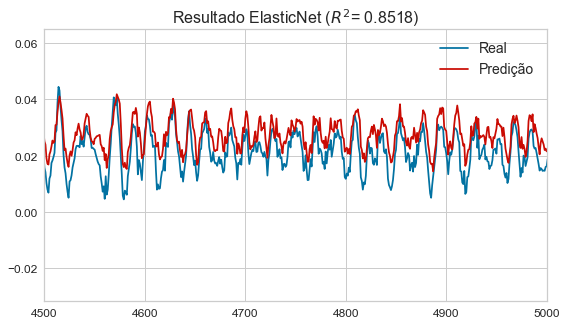

In [33]:
plt.figure(figsize=(9,5))
plt.plot(real,'b',label='Real')
plt.plot(predito,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2$= 0.8518)',size=16)
plt.xlim([4500,5000])
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(fontsize=14)

In [34]:
predito = predito.reshape(predito.shape[0],1)
residuals = real - predito

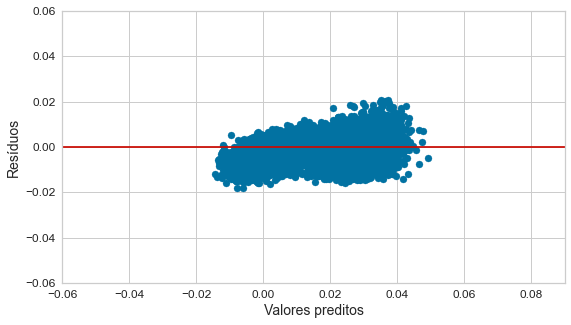

In [35]:
plt.figure(figsize=(9,5))
plt.scatter(predito,residuals)
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xlabel('Valores preditos',size=14)
plt.ylabel('Resíduos',size=14)
plt.ylim([-0.06,0.06])
plt.xlim([-0.06,0.09])
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)

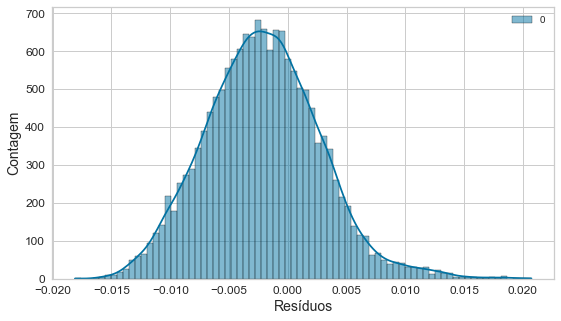

In [36]:
plt.figure(figsize=(9,5))
sns.histplot(data=residuals, kde=True,label=None)
plt.ylabel('Contagem',size=14)
plt.xlabel('Resíduos',size=14)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)

## Suport Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVR

def objective(trial):
    
        
    sv_gamma = trial.suggest_float("gamma", low=0.0001, high=1, step=0.001)
    sv_C= trial.suggest_float("C", low=0.001, high=100,step=0.05)
    sv_epsilon= trial.suggest_float("epsilon", low=0.001, high=1,step=0.01)
    
    #sv_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    
    model = SVR(gamma=sv_gamma,C=sv_C,epsilon=sv_epsilon)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
#study_svm = optuna.create_study(direction='maximize')

[I 2022-12-04 09:42:46,358] A new study created in memory with name: no-name-6d9d7fea-882b-4fb7-ad6a-fb6303b9fcab


In [ ]:
#study_svm.optimize(objective, n_trials=20,show_progress_bar=True)

#trial = study_svm.best_trial

#print('Accuracy: {}'.format(trial.value))
#print("Best hyperparameters: {}".format(trial.params))

In [ ]:
#joblib.dump(study_svm, "study_SVM.pkl")

### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

def objective(trial):
    
        
    h_n_estimators = trial.suggest_int("n_estimators", low=300, high=1000, step=25)
    h_learning_rate = trial.suggest_float("learning_rate", 0.1, 1)
    h_loss = trial.suggest_categorical("loss", ['linear', 'square', 'exponential'])
    
    model = AdaBoostRegressor(learning_rate=h_learning_rate,
                                       loss=h_loss,
                                       n_estimators=h_n_estimators,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_ab = optuna.create_study(direction='maximize')

[I 2022-12-04 10:27:50,853] A new study created in memory with name: no-name-a8e1b2ec-bf2f-49dd-81c7-a022899a8687


In [ ]:
study_ab.optimize(objective, n_trials=25)

trial_ab = study_ab.best_trial

print('Accuracy: {}'.format(trial_ab.value))
print("Best hyperparameters: {}".format(trial_ab.params))

In [ ]:
joblib.dump(study_ab, "study_AdaBost.pkl")

['study_AdaBost.pkl']

In [ ]:
optuna.visualization.plot_optimization_history(study_ab)

In [ ]:
optuna.visualization.plot_slice(study_ab)

https://medium.com/analytics-vidhya/xgboost-colsample-by-hyperparameters-explained-6c0bac1bdc1

In [ ]:
import xgboost as xgb

def objective(trial):
    
        
    #x_max_depth = trial.suggest_int("max_depth",2,20)
    #x_learning_rate = trial.suggest_float("learning_rate",0.01,0.1)
    #x_n_estimators = trial.suggest_int("n_estimators", low=50, high=600, step=10)
    #x_colsample_bytree = trial.suggest_float("bytree",0.1,0.9)
    #x_min_child_weight =  trial.suggest_int("min_child_weight",4,12)
    param = {
        'lambda': trial.suggest_loguniform('lambda',low=1e-3,high=5),
        'alpha': trial.suggest_loguniform('alpha', low=1e-3,high=5),
        'colsample_bytree': trial.suggest_float('colsample_bytree',low=0.3,high=1,step=0.1),
        'subsample': trial.suggest_float('subsample',0.1,1,step=0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 10000, 25),
        'max_depth': trial.suggest_int('max_depth',2,20,2),
        'random_state': 2020,
        'min_split_loss': trial.suggest_loguniform('min_split_loss',low=1e-3,high=0.1),
        'min_child_weight': trial.suggest_float('min_child_weight',0.1,10,step=0.5),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel',0.3,1,step=0.1),
        'colsample_bynode': trial.suggest_float('colsample_bynode',0.3,1,step=0.1)
    }
    
    model = xgb.XGBRegressor(**param)  
    
    

   
    #model.fit(X_train_scaled,y_train)
    #p=model.predict(X_test_scaled)
    #score= r2_score(y_test,p)
    
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
#study_xgbr= optuna.create_study(direction='maximize')

[I 2022-12-04 11:27:59,105] A new study created in memory with name: no-name-85c9f86f-a017-43e0-905a-4707b8fa343f


In [ ]:
study_xgbr.optimize(objective, n_trials=20)

trial_xgbr= study_xgbr.best_trial

print('Accuracy: {}'.format(trial_xgbr.value))
print("Best hyperparameters: {}".format(trial_xgbr.params))

In [ ]:
joblib.dump(study_xgbr, "study_XGBoost.pkl")

['study_XGBoost.pkl']

In [ ]:
optuna.visualization.plot_optimization_history(study_xgbr)

In [ ]:
optuna.visualization.plot_slice(study_xgbr)

In [ ]:
kajkdjhakakjhkjlkhdl

In [ ]:
study = joblib.load("study_XGBoost.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ",study.best_params)

Best trial until now:
 Value:  0.7740430126296058
 Params:  {'lambda': 0.001530808845481313, 'alpha': 0.02111400159780091, 'colsample_bytree': 0.6000000000000001, 'subsample': 0.7000000000000001, 'n_estimators': 5850, 'max_depth': 10, 'min_split_loss': 0.0027632330369892592, 'min_child_weight': 7.1, 'colsample_bylevel': 0.9000000000000001, 'colsample_bynode': 1.0}


In [ ]:
import xgboost as xgb
mdl = xgb.XGBRegressor(**study.best_params,random_state=2020)
mdl.fit(X_train_scaled,y_train)
p=mdl.predict(X_test_scaled)
score= mean_squared_error(y_test,p)
score_r2 = r2_score(y_test,p)
print("RMSE: ", score)
print("R2: ", score_r2)

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



RMSE:  0.00010128150309338829
R2:  0.7740430126296058


In [ ]:
predito_XGB = np.array(p,dtype=float)
real= np.array(y_test,dtype=float)


In [ ]:
residuals = real - predito

In [ ]:
sns.histplot(data=residuals,label='Resíduos')
plt.legend(fontsize=14)

In [ ]:
sns.boxplot(residuals)

Text(0.5, 1.0, 'Resultado XGBoost $R^2$ = 0.7740')

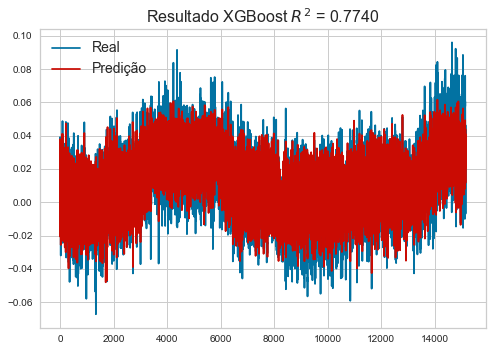

In [ ]:
plt.plot(real,'b',label='Real')
plt.plot(predito_XGB,'r',label = 'Predição')
plt.legend(fontsize=14)
plt.title('Resultado XGBoost $R^2$ = 0.7740',size=16)
#plt.xlim([9000,10000])
#plt.ylim([-0.05,0.1])
#RMSE:  0.0001065447461351567
#R2:  0.7738208762340173

In [ ]:
predicted_XGB = pd.DataFrame(p, columns = ['L/V_FR'])
predicted_XGB.to_csv(r'C:\Users\DELL\Desktop\PG\predito_xgboost.csv', index = False)
y_test.to_csv(r'C:\Users\DELL\Desktop\PG\teste_real.csv', index=False)

# Learning Curve

In [ ]:
plt.figure(figsize=(12,6))

from yellowbrick.model_selection import LearningCurve

# Load a regression dataset

# Instantiate the regression model and visualizer
#model = ElasticNet(**study_en.best_params,random_state=2020)
#visualizer = LearningCurve(model, scoring='r2')

#visualizer.fit(X_train_scaled, y_train)        # Fit the data to the visualizer
#visualizer.show()           # Finalize and render the figure

<Figure size 864x432 with 0 Axes>

# Real intrumantation IRV

In [37]:
X_IRV, y_IRV2 = df[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
'AU_FR','AU_FL','AU_BR','AU_BL','AT_X','AT_Z']], df[['L/V_FR']]
X_train_IRV,X_test_IRV,y_train_IRV,y_test_IRV = create_scaled_dataset(X_IRV,y_IRV2)

In [38]:

def objective(trial):
    
        
    h_alpha = trial.suggest_float("alpha", low=0.0001, high=1, step=0.0001)
    h_l1_ratio= trial.suggest_float("l1_ratio", low=0.0, high=1,step=0.01)
    
    h_selection = trial.suggest_categorical("selection", ['cyclic','random'])
    
    model = ElasticNet(alpha=h_alpha,l1_ratio=h_l1_ratio,
                                       
                                       selection=h_selection,
                                       random_state=0)
    model.fit(X_train_IRV,y_train_IRV)
    p=model.predict(X_test_IRV)
    score= r2_score(y_test_IRV,p)
    return score

    
study_IRV = optuna.create_study(direction='maximize')

[I 2022-12-09 13:16:31,006] A new study created in memory with name: no-name-c2e55978-084f-491d-a345-7062fcd6de93


In [39]:
study_IRV.optimize(objective, n_trials=500,show_progress_bar=True)

trial_IRV = study_IRV.best_trial

print('Accuracy: {}'.format(trial_IRV.value))
print("Best hyperparameters: {}".format(trial_IRV.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-12-09 13:16:37,734] Trial 0 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.8613000000000001, 'l1_ratio': 0.38, 'selection': 'cyclic'}. Best is trial 0 with value: -0.07451182808005496.
[I 2022-12-09 13:16:37,775] Trial 1 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.7427, 'l1_ratio': 0.49, 'selection': 'random'}. Best is trial 0 with value: -0.07451182808005496.
[I 2022-12-09 13:16:37,844] Trial 2 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.6337, 'l1_ratio': 0.4, 'selection': 'cyclic'}. Best is trial 0 with value: -0.07451182808005496.
[I 2022-12-09 13:16:37,888] Trial 3 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.8068000000000001, 'l1_ratio': 0.37, 'selection': 'cyclic'}. Best is trial 0 with value: -0.07451182808005496.
[I 2022-12-09 13:16:37,926] Trial 4 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.9914000000000001, 'l1_ratio': 0.27, 'selection': 'cycli

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.369e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:16:39,912] Trial 13 finished with value: 0.845438016332917 and parameters: {'alpha': 0.0135, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 12 with value: 0.8512349466153735.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.922e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:16:41,697] Trial 14 finished with value: 0.8411310647262435 and parameters: {'alpha': 0.1692, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 12 with value: 0.8512349466153735.
[I 2022-12-09 13:16:41,744] Trial 15 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.1748, 'l1_ratio': 0.68, 'selection': 'cyclic'}. Best is trial 12 with value: 0.8512349466153735.
[I 2022-12-09 13:16:41,797] Trial 16 finished with value: 0.8516150319035025 and parameters: {'alpha': 0.0019000000000000002, 'l1_ratio': 0.2, 'selection': 'cyclic'}. Best is trial 16 with value: 0.8516150319035025.
[I 2022-12-09 13:16:41,840] Trial 17 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.3392, 'l1_ratio': 0.2, 'selection': 'cyclic'}. Best is trial 16 with value: 0.8516150319035025.
[I 2022-12-09 13:16:41,876] Trial 18 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.1291, 'l1_ratio': 0.15, 'selection': 'random'}. Best is trial 16 with

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.340e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:16:42,781] Trial 21 finished with value: 0.845264148239483 and parameters: {'alpha': 0.0112, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 16 with value: 0.8516150319035025.
[I 2022-12-09 13:16:42,818] Trial 22 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.0873, 'l1_ratio': 0.12, 'selection': 'cyclic'}. Best is trial 16 with value: 0.8516150319035025.
[I 2022-12-09 13:16:42,869] Trial 23 finished with value: 0.8524424856495584 and parameters: {'alpha': 0.0009000000000000001, 'l1_ratio': 0.23, 'selection': 'cyclic'}. Best is trial 23 with value: 0.8524424856495584.
[I 2022-12-09 13:16:42,917] Trial 24 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.0952, 'l1_ratio': 0.27, 'selection': 'cyclic'}. Best is trial 23 with value: 0.8524424856495584.
[I 2022-12-09 13:16:42,970] Trial 25 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.2092, 'l1_ratio': 0.21, 'selection': 'cyclic'}. Best is trial 23 wit

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.650e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:16:44,898] Trial 44 finished with value: 0.8461171688115184 and parameters: {'alpha': 0.0369, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 23 with value: 0.8524424856495584.
[I 2022-12-09 13:16:44,963] Trial 45 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.1121, 'l1_ratio': 0.11, 'selection': 'cyclic'}. Best is trial 23 with value: 0.8524424856495584.
[I 2022-12-09 13:16:45,020] Trial 46 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.0505, 'l1_ratio': 0.19, 'selection': 'cyclic'}. Best is trial 23 with value: 0.8524424856495584.
[I 2022-12-09 13:16:45,066] Trial 47 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.1747, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 23 with value: 0.8524424856495584.
[I 2022-12-09 13:16:45,110] Trial 48 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.2808, 'l1_ratio': 0.53, 'selection': 'random'}. Best is trial 23 with value: 0.8

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.441e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:16:49,953] Trial 131 finished with value: 0.8457594199693044 and parameters: {'alpha': 0.0193, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 89 with value: 0.8525117555041204.
[I 2022-12-09 13:16:50,005] Trial 132 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.059300000000000005, 'l1_ratio': 0.19, 'selection': 'cyclic'}. Best is trial 89 with value: 0.8525117555041204.
[I 2022-12-09 13:16:50,053] Trial 133 finished with value: 0.45839285751024983 and parameters: {'alpha': 0.030100000000000002, 'l1_ratio': 0.15, 'selection': 'cyclic'}. Best is trial 89 with value: 0.8525117555041204.
[I 2022-12-09 13:16:50,100] Trial 134 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.8139000000000001, 'l1_ratio': 0.51, 'selection': 'cyclic'}. Best is trial 89 with value: 0.8525117555041204.
[I 2022-12-09 13:16:50,142] Trial 135 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.0786, 'l1_ratio': 0.24, 'selection':

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.622e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



[I 2022-12-09 13:17:04,687] Trial 401 finished with value: 0.8461055175020145 and parameters: {'alpha': 0.0345, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 194 with value: 0.8525237640208195.
[I 2022-12-09 13:17:04,755] Trial 402 finished with value: 0.8523378205677137 and parameters: {'alpha': 0.0016, 'l1_ratio': 0.12, 'selection': 'random'}. Best is trial 194 with value: 0.8525237640208195.
[I 2022-12-09 13:17:04,835] Trial 403 finished with value: 0.852180335573157 and parameters: {'alpha': 0.0017000000000000001, 'l1_ratio': 0.1, 'selection': 'random'}. Best is trial 194 with value: 0.8525237640208195.
[I 2022-12-09 13:17:04,891] Trial 404 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.1605, 'l1_ratio': 0.14, 'selection': 'random'}. Best is trial 194 with value: 0.8525237640208195.
[I 2022-12-09 13:17:04,931] Trial 405 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.4577, 'l1_ratio': 0.13, 'selection': 'random'}. Best is trial 

In [40]:
study_IRV.best_trial

FrozenTrial(number=194, values=[0.8525237640208195], datetime_start=datetime.datetime(2022, 12, 9, 13, 16, 52, 937251), datetime_complete=datetime.datetime(2022, 12, 9, 13, 16, 53, 2079), params={'alpha': 0.0008, 'l1_ratio': 0.31, 'selection': 'cyclic'}, distributions={'alpha': FloatDistribution(high=1.0, log=False, low=0.0001, step=0.0001), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=0.01), 'selection': CategoricalDistribution(choices=('cyclic', 'random'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=194, state=TrialState.COMPLETE, value=None)

In [41]:
mdl_IRV = ElasticNet(**study_IRV.best_params,random_state=2020)
mdl_IRV.fit(X_train_IRV,y_train_IRV)
p=mdl_IRV.predict(X_test_IRV)
score_IRV = mean_squared_error(y_test_IRV,p)
score_r2_IRV = r2_score(y_test_IRV,p)
print("RMSE: ", score_IRV)
print("R2: ", score_r2_IRV)
predito_IRV = np.array(p,dtype=float)
real_IRV= np.array(y_test_IRV,dtype=float)

RMSE:  2.8471042992013763e-05
R2:  0.8525237640208195


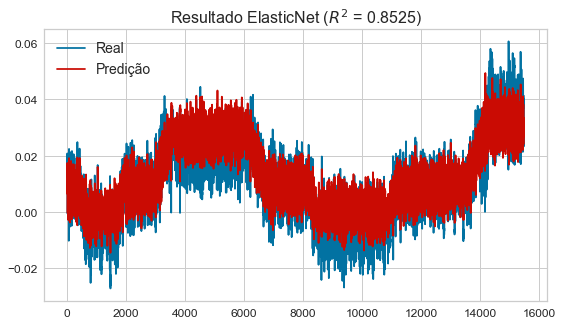

In [42]:
plt.figure(figsize=(9,5))
plt.plot(real_IRV,'b',label='Real')
plt.plot(predito_IRV,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2$ = 0.8525)',size=16)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(fontsize=14)

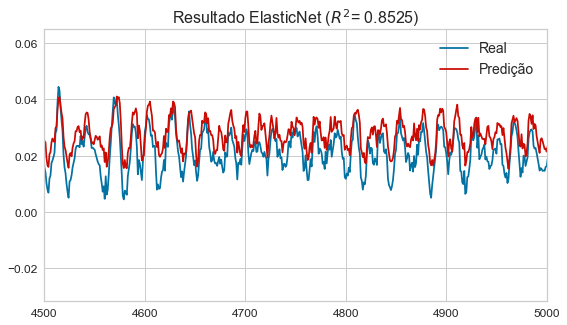

In [43]:
plt.figure(figsize=(9,5))
plt.plot(real_IRV,'b',label='Real')
plt.plot(predito_IRV,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2$= 0.8525)',size=16)
plt.xlim([4500,5000])
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(fontsize=14)

In [44]:
predito_IRV = predito_IRV.reshape(predito_IRV.shape[0],1)
residuals_IRV = real_IRV - predito_IRV

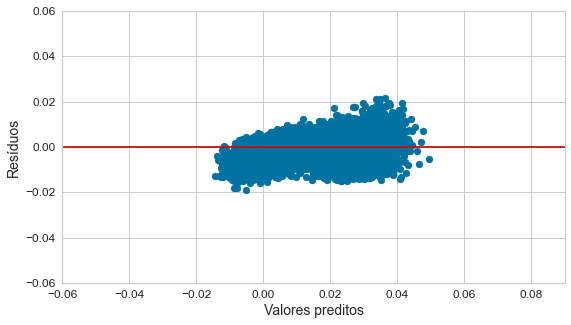

In [45]:
plt.figure(figsize=(9,5))
plt.scatter(predito_IRV,residuals_IRV)
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xlabel('Valores preditos',size=14)
plt.ylabel('Resíduos',size=14)
plt.ylim([-0.06,0.06])
plt.xlim([-0.06,0.09])
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)

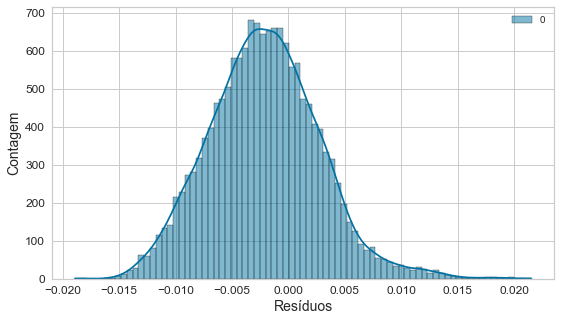

In [46]:
plt.figure(figsize=(9,5))
sns.histplot(data=residuals_IRV, kde=True,label=None)
plt.ylabel('Contagem',size=14)
plt.xlabel('Resíduos',size=14)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)